<a href="https://colab.research.google.com/github/sidrusiya/AILA_KFolds/blob/main/SUM_AILA_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns
import gensim
nltk.download('all')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
dataset = open('/content/drive/MyDrive/nit_agartala_nlp_team_3.tsv', 'r')
df = pd.read_csv(dataset, sep='\t')

In [ ]:
df.head()

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...


In [ ]:
df['judge_id'].max()

500

In [ ]:
df1 = df[df['judge_id'] <= 400]
df2 = df[df['judge_id'] > 400]

df1

,judge_id,id,sentence,relevance,lem_text,stem_text
0,1,1,Appeal by special leave from the order dated ...,0,appeal special leave order dated government pu...,appeal special leav order date govern punjab (...
1,2,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . bombay high court app...,judgment order date . . bombay high court appe...
2,3,1,Appeal from the judgment and decree dated rd/t...,0,appeal judgment decree dated rd/th calcutta hi...,appeal judgment decre date rd/th calcutta high...
3,4,1,of .,0,.,.
4,5,1,From the Judgment and order dated . . of the ...,0,judgment order dated . . allahabad high court ...,judgment order date . . allahabad high court c...
...,...,...,...,...,...,...
72187,27,2541,The petitioner before us does not complain tha...,0,petitioner u complain got proper grounds.,petition us complain got proper grounds.
72188,27,2542,Further the period of his detention under the ...,0,period detention impugned act gone beyond thre...,period detent impugn act gone beyond three mon...
72189,27,2543,Petition dismissed.,0,petition dismissed.,petit dismissed.
72190,27,2544,Agent for the petitioner: S. Subrahmanyam.,0,agent petitioner: s. subrahmanyam.,agent petitioner: s. subrahmanyam.


In [ ]:
df2

,judge_id,id,sentence,relevance,lem_text,stem_text
400,401,1,Appeal by special leave from the judgment and ...,0,appeal special leave judgment order dated _the...,appeal special leav judgment order date _the m...
401,402,1,Appeal from Judgment and Order dated the th da...,0,appeal judgment order dated th day june high c...,appeal judgment order date th day june high co...
402,403,1,Appeal by Special leave from the Judgment and ...,0,appeal special leave judgment order dated rd j...,appeal special leav judgment order date rd jan...
403,404,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . andhra pradesh admini...,judgment order date . . andhra pradesh adminis...
404,405,1,Appeal by Special Leave from the Award of the ...,0,appeal special leave award industrial tribunal...,appeal special leav award industri tribun guja...
...,...,...,...,...,...,...
69217,409,1201,The interim orders passed by this Court are va...,0,interim order passed court vacated.,interim order pass court vacated.
69223,409,1202,The amount of rupees which the Indian shareho...,0,amount rupee indian shareholder directed pay h...,amount rupe indian sharehold direct pay hold c...
69229,409,1203,The interim Board of Directors shall forthwith...,1,interim board director shall forthwith hand ch...,interim board director shall forthwith hand ch...
69235,409,1204,After taking the charge from the interim Board...,0,taking charge interim board board director tak...,take charg interim board board director take e...


In [ ]:
max_classes = len(df1.relevance.unique())

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(df)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df1.lem_text, df1.relevance, 
                                                    test_size = 0.1, random_state = 42, stratify =df1.relevance)

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_model_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(bert_model_preprocessing_link)

In [ ]:
bert_model = hub.KerasLayer(bert_model_link)

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name='input-text')
    preprocessing_layer = hub.KerasLayer(bert_model_preprocessing_link, name='bert-preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_link, trainable=True, name='bert-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units= 512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units=max_classes, activation='softmax', name='classifer')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(sample_text))

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 bert-preprocessing (KerasLayer  {'input_mask': (Non  0          ['input-text[0][0]']             
 )                              e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

num_train_steps =  len((df1.relevance) // batch_size) * EPOCHS
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate=0.,
                               decay_steps=num_train_steps
                               )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('/content/checkpoints',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               save_weights_only = False)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

In [ ]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight='balanced'
                                               ,classes=np.unique(df1.relevance)
                                               ,y=df1.relevance)

class_weights_array

array([0.6463312, 2.2084532])

In [ ]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.6463311961660514, 1: 2.2084531976100905}

In [ ]:
import tensorflow_addons as tfa

macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

metrics = [categorical_accuracry, micro_f1, precision, recall]

In [ ]:
classifier_model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_labels_train)).shuffle(40000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_labels_test)).shuffle(40000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
classifier_model.fit(train_dataset,
                     validation_data=test_dataset,
                 epochs = EPOCHS,
                 verbose = 1,
                 class_weight=class_weights,
                 callbacks = [MyCheckpoint, MyEarlyStopping]
          )

Epoch 1/3
1685/1685 [==============================] - ETA: 0s - loss: 0.6648 - categorical_accuracy: 0.5850 - f1_score: 0.5850 - precision: 0.5850 - recall: 0.5850
Epoch 00001: val_categorical_accuracy improved from -inf to 0.63477, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


1685/1685 [==============================] - 2927s 2s/step - loss: 0.6648 - categorical_accuracy: 0.5850 - f1_score: 0.5850 - precision: 0.5850 - recall: 0.5850 - val_loss: 0.6147 - val_categorical_accuracy: 0.6348 - val_f1_score: 0.6348 - val_precision: 0.6348 - val_recall: 0.6348
Epoch 2/3
1685/1685 [==============================] - ETA: 0s - loss: 0.5843 - categorical_accuracy: 0.6765 - f1_score: 0.6765 - precision: 0.6765 - recall: 0.6765
Epoch 00002: val_categorical_accuracy improved from 0.63477 to 0.65598, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


1685/1685 [==============================] - 2912s 2s/step - loss: 0.5843 - categorical_accuracy: 0.6765 - f1_score: 0.6765 - precision: 0.6765 - recall: 0.6765 - val_loss: 0.5713 - val_categorical_accuracy: 0.6560 - val_f1_score: 0.6560 - val_precision: 0.6560 - val_recall: 0.6560
Epoch 3/3
1685/1685 [==============================] - ETA: 0s - loss: 0.4872 - categorical_accuracy: 0.7522 - f1_score: 0.7522 - precision: 0.7522 - recall: 0.7522
Epoch 00003: val_categorical_accuracy improved from 0.65598 to 0.66399, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


1685/1685 [==============================] - 2907s 2s/step - loss: 0.4872 - categorical_accuracy: 0.7522 - f1_score: 0.7522 - precision: 0.7522 - recall: 0.7522 - val_loss: 0.5783 - val_categorical_accuracy: 0.6640 - val_f1_score: 0.6640 - val_precision: 0.6640 - val_recall: 0.6640


In [ ]:
classifier_model.save('BERT-Model.h5') 

In [ ]:
y_preds = np.argmax(classifier_model.predict(df2.lem_text), axis=1)
y_preds

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
df2['pred_relevance'] = y_preds
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,judge_id,id,sentence,relevance,lem_text,stem_text,pred-relevance,pred_relevance
400,401,1,Appeal by special leave from the judgment and ...,0,appeal special leave judgment order dated _the...,appeal special leav judgment order date _the m...,0,0
401,402,1,Appeal from Judgment and Order dated the th da...,0,appeal judgment order dated th day june high c...,appeal judgment order date th day june high co...,0,0
402,403,1,Appeal by Special leave from the Judgment and ...,0,appeal special leave judgment order dated rd j...,appeal special leav judgment order date rd jan...,0,0
403,404,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . andhra pradesh admini...,judgment order date . . andhra pradesh adminis...,0,0
404,405,1,Appeal by Special Leave from the Award of the ...,0,appeal special leave award industrial tribunal...,appeal special leav award industri tribun guja...,0,0
...,...,...,...,...,...,...,...,...
69217,409,1201,The interim orders passed by this Court are va...,0,interim order passed court vacated.,interim order pass court vacated.,1,1
69223,409,1202,The amount of rupees which the Indian shareho...,0,amount rupee indian shareholder directed pay h...,amount rupe indian sharehold direct pay hold c...,1,1
69229,409,1203,The interim Board of Directors shall forthwith...,1,interim board director shall forthwith hand ch...,interim board director shall forthwith hand ch...,0,0
69235,409,1204,After taking the charge from the interim Board...,0,taking charge interim board board director tak...,take charg interim board board director take e...,1,1


              precision    recall  f1-score   support

           0       0.82      0.62      0.71      9288
           1       0.34      0.60      0.43      3024

    accuracy                           0.61     12312
   macro avg       0.58      0.61      0.57     12312
weighted avg       0.70      0.61      0.64     12312



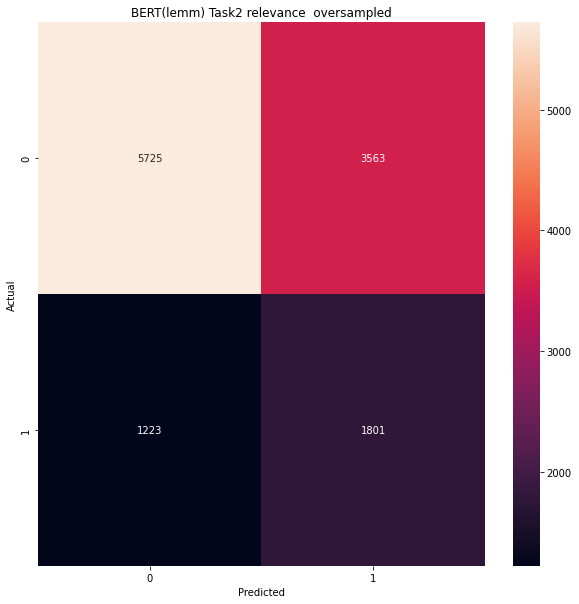

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df2.relevance,df2.pred_relevance))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(df2.relevance), list(df2['pred_relevance']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(df2.relevance), yticklabels=set(df2.relevance))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('BERT(lemm) Task2 relevance  oversampled')
plt.show()

In [ ]:
dataset = open('/content/drive/MyDrive/nit_agartala_nlp_team2_1.tsv', 'r')
df2 = pd.read_csv(dataset, sep='\t')
df2

,judge_id,id,sentence,relevance,lem_text,stem_text,pred_relevance
0,401,1,Appeal by special leave from the judgment and ...,0,appeal special leave judgment order dated _the...,appeal special leav judgment order date _the m...,0
1,402,1,Appeal from Judgment and Order dated the th da...,0,appeal judgment order dated th day june high c...,appeal judgment order date th day june high co...,0
2,403,1,Appeal by Special leave from the Judgment and ...,0,appeal special leave judgment order dated rd j...,appeal special leav judgment order date rd jan...,0
3,404,1,From the Judgment and Order dated . . of the ...,0,judgment order dated . . andhra pradesh admini...,judgment order date . . andhra pradesh adminis...,0
4,405,1,Appeal by Special Leave from the Award of the ...,0,appeal special leave award industrial tribunal...,appeal special leav award industri tribun guja...,0
...,...,...,...,...,...,...,...
12307,409,1201,The interim orders passed by this Court are va...,0,interim order passed court vacated.,interim order pass court vacated.,1
12308,409,1202,The amount of rupees which the Indian shareho...,0,amount rupee indian shareholder directed pay h...,amount rupe indian sharehold direct pay hold c...,0
12309,409,1203,The interim Board of Directors shall forthwith...,1,interim board director shall forthwith hand ch...,interim board director shall forthwith hand ch...,1
12310,409,1204,After taking the charge from the interim Board...,0,taking charge interim board board director tak...,take charg interim board board director take e...,0


In [ ]:
summary_file= pd.DataFrame(columns=['judge_id', 'summary', 'pred_summary'])
for i in range(100):
      summary_file= summary_file.append({'judge_id': i+401,  'summary': '', 'pred_summary': ''}, ignore_index=True)

In [ ]:
for i in df2.index:
  if df2['relevance'][i]:
    summary_file['summary'][df2['judge_id'][i]-401]+=(df2['sentence'][i])
  if df2['pred_relevance'][i]:
    summary_file['pred_summary'][df2['judge_id'][i]-401]+=(df2['sentence'][i])

summary_file

,judge_id,summary,pred_summary
0,401,The appellant is a firm consisting of six part...,The partnership was registered under the India...
1,402,Sannyasi charan Sadhukhan died in and his son...,The controversy arose at the time of the asses...
2,403,The following question of law had been referre...,The matter came up before a Division Bench of ...
3,404,Special leave granted.Pending prosecution with...,Special leave granted.For immediate reference ...
4,405,In the case of the Alembic Glass Industries li...,The workmen particularly felt aggrieved becaus...
...,...,...,...
95,496,Punjab Excise Act has been extended to Delhi....,To illumine the contours of controversy events...
96,497,In support of his first contention reliance wa...,The mortgaged properties were put up for sale ...
97,498,These appointments seem to have been made vari...,In another Department of the Government of Mad...
98,499,The revenue authorities sanctioned mutation of...,The revenue authorities sanctioned mutation of...


In [ ]:
pip install bert-extractive-summarizer

In [ ]:
from summarizer import Summarizer
model = Summarizer()

for i in summary_file.index:
    sumx = model(summary_file.summary[i], min_length=20)
    summary_file.summary[i] = "".join(sumx)
    sumz = model(summary_file.pred_summary[i], min_length=20)
    summary_file.pred_summary[i] = "".join(sumz)


In [ ]:
!pip install git+https://github.com/tagucci/pythonrouge.git

  Cloning https://github.com/tagucci/pythonrouge.git to /tmp/pip-req-build-ibnwj0lf
  Running command git clone -q https://github.com/tagucci/pythonrouge.git /tmp/pip-req-build-ibnwj0lf
  Created wheel for pythonrouge: filename=pythonrouge-0.2-py3-none-any.whl size=285411 sha256=b1acc3c18668b261b44b88b277e65672ccc6b6d577cffaf28a9e8ed66e694379
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdrrqag7/wheels/f2/28/1a/47e2c73d5e7d1d49296a991e19d774c97e4c2e98dbf027a515
Successfully built pythonrouge


In [ ]:
!pip install rouge

from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(summary_file['pred_summary'][0], summary_file['summary'][0])

In [ ]:
scores

[{'rouge-1': {'f': 0.72173215225054,
   'p': 0.6437768240343348,
   'r': 0.8211678832116789},
  'rouge-2': {'f': 0.5787159141704117,
   'p': 0.5119294605809128,
   'r': 0.6655428186109238},
  'rouge-l': {'f': 0.7072975091069955,
   'p': 0.630901287553648,
   'r': 0.8047445255474452}}]

In [ ]:
predictions = summary_file['pred_summary'].to_list()
targets = summary_file['summary'].to_list()
predictions = [" ".join(prediction).lower() for prediction in predictions]
predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
targets = [" ".join(target).lower() for target in targets]
targets = [target if target else "EMPTY" for target in targets]

In [ ]:
scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)

scores